In [1]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load the dataset
# df = pd.read_csv("BBBP.csv")

# # Rename the column CT_TOX to clintox
# df.rename(columns={'p_np': 'BBBP'}, inplace=True)

# # Split the data into training (80%) and temp (20%)
# train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['BBBP'], random_state=42)

# # Split the temp data into validation (10%) and test (10%)
# valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['BBBP'], random_state=42)

# # Add the group column
# train_df['group'] = 'training'
# valid_df['group'] = 'valid'
# test_df['group'] = 'test'

# # Concatenate the dataframes back together
# final_df = pd.concat([train_df, valid_df, test_df])

# # Save the final dataframe to a new CSV
# final_df.to_csv("BBBP_with_groups.csv", index=False)

In [1]:
dataset_name = 'Mutagenicity' # Choose from 'Mutagenicity', 'hERG', 'BBBP', 'clintox'
date_tag = '0930'
least_count = 20

# Loading Dataset

In [2]:
import torch
import pandas as pd
# Check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from DataLoader import MolDataset
training_data = MolDataset(root=".", split='training',csv_file=f"{dataset_name}.csv")
validation_data = MolDataset(root=".", split='valid',csv_file=f"{dataset_name}.csv")
test_data = MolDataset(root=".", split='test',csv_file=f"{dataset_name}.csv")

In [4]:
training_data.num_classes, len(training_data), training_data.num_node_features, training_data.num_edge_features

(2, 6137, 26, 8)

In [5]:
validation_data.num_classes, len(validation_data), validation_data.num_node_features, validation_data.num_edge_features

(2, 767, 26, 8)

In [6]:
test_data.num_classes, len(test_data), test_data.num_node_features, test_data.num_edge_features

(2, 768, 26, 8)

In [7]:
import numpy as np
def remove_bad_mols(dataset):
    indices_to_remove = np.ones(len(dataset), dtype=bool)
    for i,data in enumerate(dataset):
        if data is None: 
            indices_to_remove[i] = False
        elif data.num_nodes == 0:
            print(f"Skipping molecule {data['smiles']} since it "
                      f"resulted in zero atoms")
            indices_to_remove[i] = False

    return dataset[indices_to_remove]
training_data = remove_bad_mols(training_data)
validation_data = remove_bad_mols(validation_data)
test_data = remove_bad_mols(test_data)

In [8]:
training_data.num_classes, len(training_data), training_data.num_node_features, training_data.num_edge_features

(2, 6137, 26, 8)

In [9]:
validation_data.num_classes, len(validation_data), validation_data.num_node_features, validation_data.num_edge_features

(2, 767, 26, 8)

In [10]:
test_data.num_classes, len(test_data), test_data.num_node_features, test_data.num_edge_features

(2, 768, 26, 8)

# Create Motif Vocabulary

In [11]:
from rdkit import Chem
def mol_with_atom_index(mol):
    '''
    Add Atom indices to a Rdkit molecule
    Input: Rdkit molecule object
    '''
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def get_mol(smiles, set_atom_index = True):
    '''
    Coverts a Smiles String to a Rdkit Molecule
    Input: Smiles representation of molecule, flag to recreate atom indexs 
    CCCC
    C1C2C3C4
    '''
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    # Check if smiles has index using Rdkit function
    if set_atom_index:
        return mol_with_atom_index(mol)
    else:
        return mol

In [12]:
from collections import defaultdict
from collections import Counter

def atom_counts(smiles):
    # Parse the SMILES string to a molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    assert(mol.GetNumAtoms() > 0)
    
    # Extract atoms from the molecule
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    
    # Count occurrences of each atom
    atom_count = Counter(atoms)
    
    # Sort atoms alphabetically and create the result string
    sorted_atoms = sorted(atom_count.items())
    result = ''.join(f"{atom}{count}" for atom, count in sorted_atoms)
    
    return result


class MotifDictionary:
    def __init__(self):
        self.data = defaultdict(lambda: defaultdict())
        self.test_data = defaultdict(lambda: defaultdict())
        self.motifs_length = defaultdict()
        self.motifs_class = defaultdict(dict)
        self.test_motifs_length = defaultdict()

    def add_entry(self, graph_str, motif_str, nodes, class_id):
        '''
        Maps a Graph String and nodes within the graph to a Motif String
        '''
        # motif_str = atom_counts(motif_str)
        for element in nodes:
            if element is not None:
                self.data[graph_str][element]= motif_str 
        self.motifs_class[motif_str][graph_str] = class_id
        self.motifs_length[motif_str]= len(nodes) - nodes.count(None)
        
    def add_entry_test(self, graph_str, motif_str, nodes, class_id):
        '''
        Maps a Graph String and nodes within the graph to a Motif String
        '''
        # motif_str = atom_counts(motif_str)
        for element in nodes:
            if element is not None:
                
                self.test_data[graph_str][element]= motif_str 
                
        self.test_motifs_length[motif_str]= len(nodes) - nodes.count(None)

    def query_by_graph(self, graph_str):
        '''
        Returns Nodes to Motif_String map
        '''
        return self.data.get(graph_str, {})
    
    def query_by_test_graph(self, graph_str):
        '''
        Returns Nodes to Motif_String map
        '''
        return self.test_data.get(graph_str, {})
    
    def remove_motifs(self, list_of_motifs_to_remove):
        '''
        Removes less frequent motifs
        '''
        for key in list_of_motifs_to_remove:
            self.motifs_length.pop(key)
            self.motifs_class.pop(key)

    def get_all_unique_motif(self):
        '''
        All unique motifs
        '''
        return list(self.motifs_length.keys())
    
    def get_motif_lengths(self):
        return self.motifs_length
    
    def get_test_motif_lengths(self):
        return self.test_motifs_length

In [13]:

lookup = MotifDictionary()

In [14]:
from collections import defaultdict
from rdkit import Chem
from rBRICS_public import *
from rdkit.Chem import BRICS
# from rdkit.Chem.BRICS import FindBRICSBonds, BreakBRICSBonds

def canonicalize_fragment(fragment):
    sorted_atoms = sorted(fragment.GetAtoms(), key=lambda atom: atom.GetSymbol())
    return Chem.MolToSmiles(sorted_atoms, isomericSmiles=True)

def process_molecule(smiles_string, original_mol=True):
    """Creates an RDKit molecule and preserves atom indices if not the original molecule."""
    if original_mol:
        molecule = get_mol(smiles_string)
    else:
        molecule = get_mol(smiles_string, set_atom_index=False)
    Chem.SanitizeMol(molecule)
    return molecule

def fragment_molecule(molecule):
    """Break the molecule into fragments using BRICS."""
    pbonds = list(FindrBRICSBonds(molecule))
    ppieces3 = BreakrBRICSBonds(molecule, pbonds)
    return Chem.GetMolFrags(ppieces3, asMols=True)

def brics_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []
    breaks = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        cliques.append([a1, a2])

    res = list(BRICS.FindBRICSBonds(mol))
    if len(res) == 0:
        return [list(range(n_atoms))], []
    else:
        for bond in res:
            if [bond[0][0], bond[0][1]] in cliques:
                cliques.remove([bond[0][0], bond[0][1]])
            else:
                cliques.remove([bond[0][1], bond[0][0]])
            cliques.append([bond[0][0]])
            cliques.append([bond[0][1]])

    # break bonds between rings and non-ring atoms
    for c in cliques:
        if len(c) > 1:
            if mol.GetAtomWithIdx(c[0]).IsInRing() and not mol.GetAtomWithIdx(c[1]).IsInRing():
                cliques.remove(c)
                cliques.append([c[1]])
                breaks.append(c)
            if mol.GetAtomWithIdx(c[1]).IsInRing() and not mol.GetAtomWithIdx(c[0]).IsInRing():
                cliques.remove(c)
                cliques.append([c[0]])
                breaks.append(c)

    # select atoms at intersections as motif
    for atom in mol.GetAtoms():
        if len(atom.GetNeighbors()) > 2 and not atom.IsInRing():
            cliques.append([atom.GetIdx()])
            for nei in atom.GetNeighbors():
                if [nei.GetIdx(), atom.GetIdx()] in cliques:
                    cliques.remove([nei.GetIdx(), atom.GetIdx()])
                    breaks.append([nei.GetIdx(), atom.GetIdx()])
                elif [atom.GetIdx(), nei.GetIdx()] in cliques:
                    cliques.remove([atom.GetIdx(), nei.GetIdx()])
                    breaks.append([atom.GetIdx(), nei.GetIdx()])
                cliques.append([nei.GetIdx()])

    # merge cliques
    for c in range(len(cliques) - 1):
        if c >= len(cliques):
            break
        for k in range(c + 1, len(cliques)):
            if k >= len(cliques):
                break
            if len(set(cliques[c]) & set(cliques[k])) > 0:
                cliques[c] = list(set(cliques[c]) | set(cliques[k]))
                cliques[k] = []
        cliques = [c for c in cliques if len(c) > 0]
    cliques = [c for c in cliques if len(c) > 0]

    # edges
    edges = []
    for bond in res:
        for c in range(len(cliques)):
            if bond[0][0] in cliques[c]:
                c1 = c
            if bond[0][1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))
    for bond in breaks:
        for c in range(len(cliques)):
            if bond[0] in cliques[c]:
                c1 = c
            if bond[1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))

    return cliques, edges

def extract_clique_fragments(mol, cliques):
    
    fragments = []
    
    # Iterate over each clique
    for clique in cliques:
        # Create a new editable molecule for the fragment
        editable_mol = Chem.RWMol()

        # Mapping of original atom indices to new indices in the fragment
        atom_map = {}

        # Add atoms from the clique to the new molecule
        for atom_idx in clique:
            atom = mol.GetAtomWithIdx(atom_idx)
            new_idx = editable_mol.AddAtom(atom)
            atom_map[atom_idx] = new_idx  # Map original index to new fragment index

        # Add bonds between the atoms in the clique
        added_bonds = set()  # Track bonds that have been added to avoid duplicates
        for atom_idx in clique:
            for neighbor in mol.GetAtomWithIdx(atom_idx).GetNeighbors():
                neighbor_idx = neighbor.GetIdx()
                if neighbor_idx in clique:
                    # Create a sorted tuple of atom indices to avoid duplicate bonds
                    bond_tuple = tuple(sorted([atom_idx, neighbor_idx]))
                    if bond_tuple not in added_bonds:
                        # Add the bond between the atoms in the clique
                        bond = mol.GetBondBetweenAtoms(atom_idx, neighbor_idx)
                        if bond:
                            editable_mol.AddBond(atom_map[atom_idx], atom_map[neighbor_idx], bond.GetBondType())
                            added_bonds.add(bond_tuple)  # Mark the bond as added

        # Sanitize and append the fragment molecule
        fragment = editable_mol.GetMol()
        # Disable Kekulization and sanitize the molecule with Kekulization turned off
        Chem.SanitizeMol(fragment, Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)

        fragments.append(fragment)
    
    return fragments


def handle_fragment(fragment, molecule_smiles, data, is_test=False):
    """Handle a fragment by checking if it can be further broken down or adding it to the lookup."""
    fbonds = list(FindrBRICSBonds(fragment))
    if len(fbonds) == 0:
        atom_nums = [atom.GetAtomMapNum() if atom.GetAtomicNum() != 0 else None for atom in fragment.GetAtoms()]
        [a.SetAtomMapNum(0) for a in fragment.GetAtoms()]  # Remove atom map for unique motif
        fragment_smiles = Chem.MolToSmiles(fragment, isomericSmiles=False, canonical=True)
        if is_test:
            lookup.add_entry_test(molecule_smiles, fragment_smiles, atom_nums, data.y.item())
        else:
            lookup.add_entry(molecule_smiles, fragment_smiles, atom_nums, data.y.item())
    else:
        fragment_smiles = Chem.MolToSmiles(fragment)
        return fragment_smiles

def process_dataset(dataset, is_test=False):
    """Processes a dataset (train/test) and fragments each molecule."""
    
    # [extract_clique_fragments(Chem.MolFromSmiles(i.smiles), brics_decomp(Chem.MolFromSmiles(i.smiles))[0]) for _, i in df.iterrows()]
    for i, data in enumerate(dataset):
        molecule_smiles = data["smiles"]
        # to_process = [molecule_smiles]
        original_mol = True
        
        # while to_process:
        # smiles_string = to_process.pop()
        molecule = process_molecule(molecule_smiles, original_mol)
            # original_mol = False
            
            # all_fragments = fragment_molecule(molecule)
            
        mgssl_fragments_cliques, edges_to_break = brics_decomp(molecule)
        all_fragments = extract_clique_fragments(molecule, mgssl_fragments_cliques)
            
#             input(all_fragments)
            
#             input(mgssl_fragments_cliques)
            
#             input(edges)
            
            
        for fragment in all_fragments:
            atom_nums = [atom.GetAtomMapNum() if atom.GetAtomicNum() != 0 else None for atom in fragment.GetAtoms()]
            for a in fragment.GetAtoms():  # Remove atom map for unique motif
                a.SetAtomMapNum(0) 
            fragment_smiles = Chem.MolToSmiles(fragment, isomericSmiles=False, canonical=True)
            if is_test:
                lookup.add_entry_test(molecule_smiles, fragment_smiles, atom_nums, data.y.item())
            else:
                lookup.add_entry(molecule_smiles, fragment_smiles, atom_nums, data.y.item())
            # fragment_smiles = handle_fragment(fragment, molecule_smiles, data, is_test)
            # if fragment_smiles:
            #     to_process.append(fragment_smiles)
                
# Process training and validation datasets
process_dataset(training_data + validation_data)

# Process test dataset
process_dataset(test_data, is_test=True)

In [15]:
len(lookup.get_all_unique_motif())

3399

In [16]:
data_lookup = dict(lookup.data)
test_data_lookup = dict(lookup.test_data)

## Unit Testing. Check if number of motifs in each graph match

In [19]:
from collections import Counter
# Count all motifs in each graph / divided by size of motif
total_motifs = 0
total_motifs_test = 0
for smiles, node_map in data_lookup.items():
    
    for node_idx, motif in node_map.items():
        
        length_of_motif = lookup.motifs_length[motif] 
        total_motifs += 1/length_of_motif



# Flatten the nested dictionary into a list of strings
all_values = [value for inner_dict in data_lookup.values() for value in inner_dict.values()]
all_values_test = [value for inner_dict in test_data_lookup.values() for value in inner_dict.values()]

# Count occurrences of each unique value
value_counts = Counter(all_values)
value_counts_test = Counter(all_values_test)
    

In [20]:
verify_motif_count = 0
motif_count_list = {}
for motifs, length in lookup.motifs_length.items():
    verify_motif_count += value_counts[motifs]/length
    motif_count_list[motifs] = value_counts[motifs]/length
motif_count_list_test = {}
for motifs, length in lookup.test_motifs_length.items():
    motif_count_list_test[motifs] = value_counts_test[motifs]/length

In [21]:
assert(round(total_motifs) == round(verify_motif_count))

In [22]:
round(total_motifs), round(verify_motif_count)

(95151, 95151)

In [23]:
len([k for k,v in motif_count_list.items() if v < least_count])

1267

In [24]:
len([k for k,v in motif_count_list_test.items() if v < least_count])

433

# Filtering motifs that are same acrooss bothe classes

In [25]:
# motif_list = list(lookup.get_all_unique_motif())
# graph_to_motifs = defaultdict(set)
# data_lookup = dict(lookup.data)
# for graph_str, value in data_lookup.items():
#     for node_id, m_str in data_lookup[graph_str].items():
#         if value_counts[m_str] > least_count:
#             try:
#                 data_lookup[graph_str][node_id] = (m_str, motif_list.index(m_str))
#                 # motif_occurence.append(m_str)
#                 graph_to_motifs[graph_str].add(motif_list.index(m_str))
#             except ValueError as e:
#                 input(m_str)
#                 # Support for future developement in freezing % motifs
#                 data_lookup[graph_str][node_id] = (m_str, None)
#         else:
#             data_lookup[graph_str][node_id] = (m_str, None)
motif_list = list(lookup.get_all_unique_motif())
graph_to_motifs = defaultdict(set)
data_lookup = dict(lookup.data)

list_of_motif_to_remove = set()
for graph_str, value in data_lookup.items():
    for node_id, m_str in data_lookup[graph_str].items():
        if motif_count_list[m_str] <= least_count:
            list_of_motif_to_remove.add(m_str)
            
lookup.remove_motifs(list(list_of_motif_to_remove))
            
            
motif_list = list(lookup.get_all_unique_motif())
graph_to_motifs = defaultdict(set)
data_lookup = dict(lookup.data)
for graph_str, value in data_lookup.items():
    for node_id, m_str in data_lookup[graph_str].items():
        if motif_count_list[m_str] > least_count:
            data_lookup[graph_str][node_id] = (m_str, motif_list.index(m_str))
            graph_to_motifs[graph_str].add(motif_list.index(m_str))
            
        else:
            data_lookup[graph_str][node_id] = (m_str, None)

In [26]:
test_graph_to_motifs = defaultdict(set)
for graph_str, value in test_data_lookup.items():
    for node_id, m_str in test_data_lookup[graph_str].items():
        try:
            test_data_lookup[graph_str][node_id] = (m_str, motif_list.index(m_str))
            # motif_occurence.append(m_str)
            test_graph_to_motifs[graph_str].add(motif_list.index(m_str))
        except ValueError as e:
            # input(m_str)
            # Support for future developement in freezing % motifs
            test_data_lookup[graph_str][node_id] = (m_str, None)

# Saved lookup table

In [27]:
import pickle
data_lookup = dict(lookup.data)
# Open a file in write mode
with open(f'dictionary/{dataset_name}_graph_lookup_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(data_lookup, file)

with open(f'dictionary/{dataset_name}_motif_list_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(list(lookup.get_all_unique_motif()), file)
    
with open(f'dictionary/{dataset_name}_motif_length_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(lookup.get_motif_lengths(), file)
    
with open(f'dictionary/{dataset_name}_motif_counts_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(value_counts, file)


In [28]:
with open(f'dictionary/{dataset_name}_motif_class_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(lookup.motifs_class, file)
    
with open(f'dictionary/{dataset_name}_graph_motifidx_{date_tag}.pickle', 'wb') as file:
    pickle.dump(graph_to_motifs, file)
    
with open(f'dictionary/{dataset_name}_test_graph_motifidx_{date_tag}.pickle', 'wb') as file:
    pickle.dump(test_graph_to_motifs, file)

In [29]:
with open(f'dictionary/{dataset_name}_test_graph_lookup_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(test_data_lookup, file)
    
with open(f'dictionary/{dataset_name}_test_graph_motif_length_{date_tag}.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(lookup.get_test_motif_lengths(), file)

# Visualization of motif occurences in dataset

In [30]:
def count_binary_values(input_dict):
    output_dict = {}
    for key, graph_label in input_dict.items():
        values = list(graph_label.values())
        count_0 = values.count(0)
        count_1 = values.count(1)
        output_dict[key] = (count_0, count_1)
    return output_dict

value_counts = count_binary_values(lookup.motifs_class)

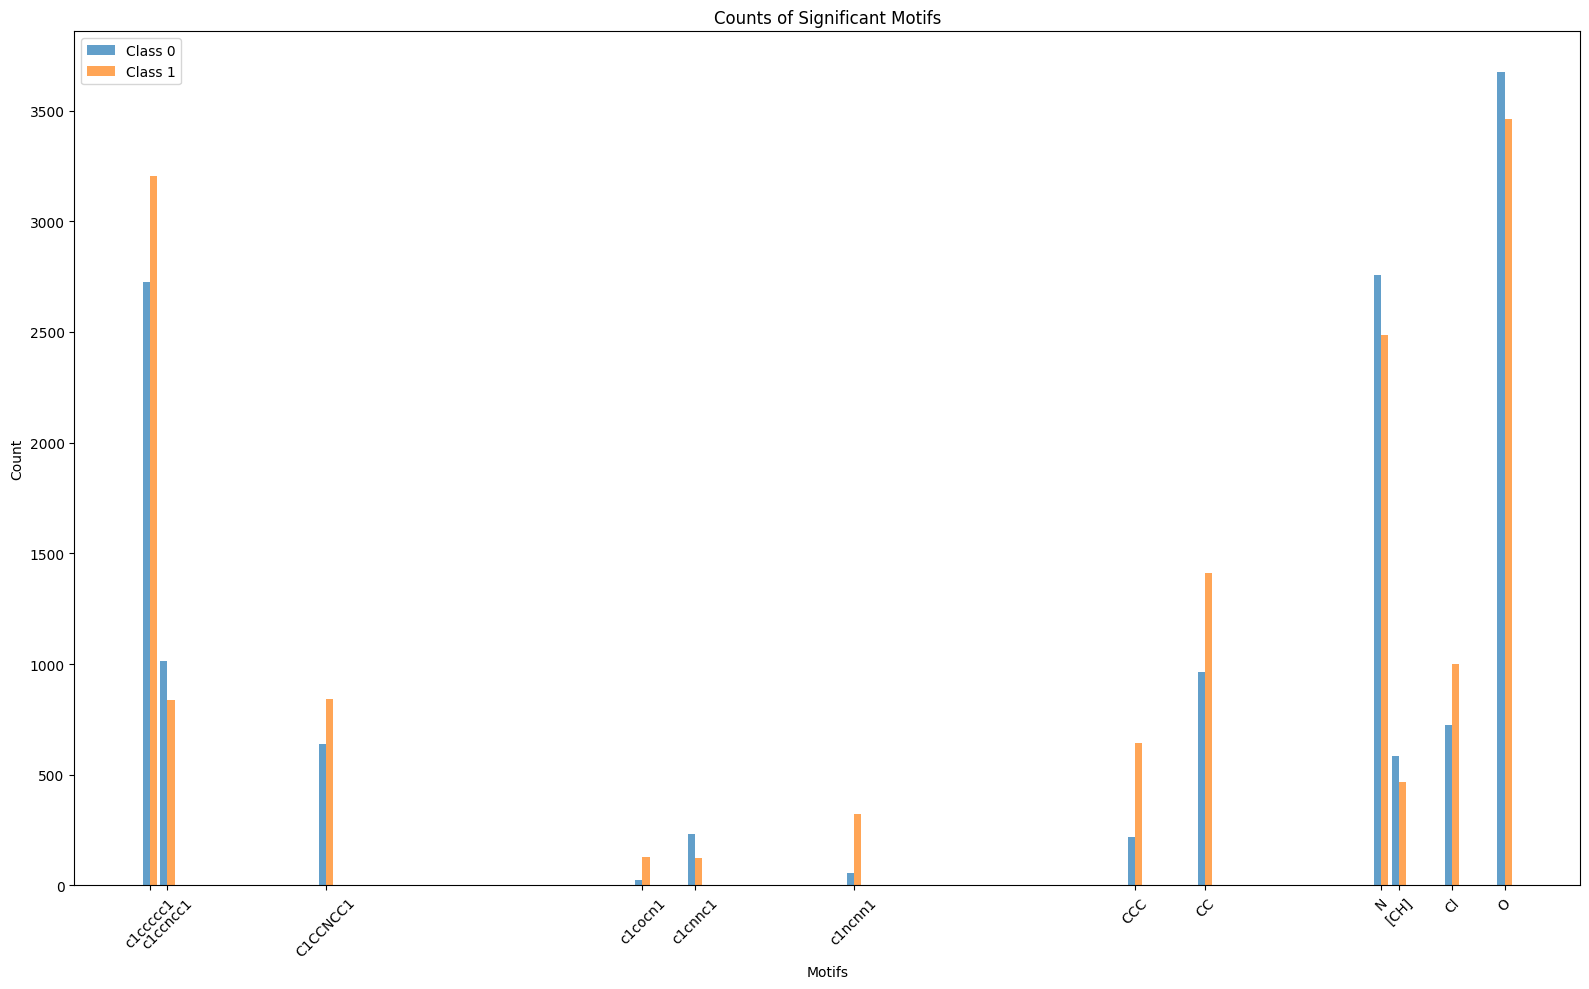

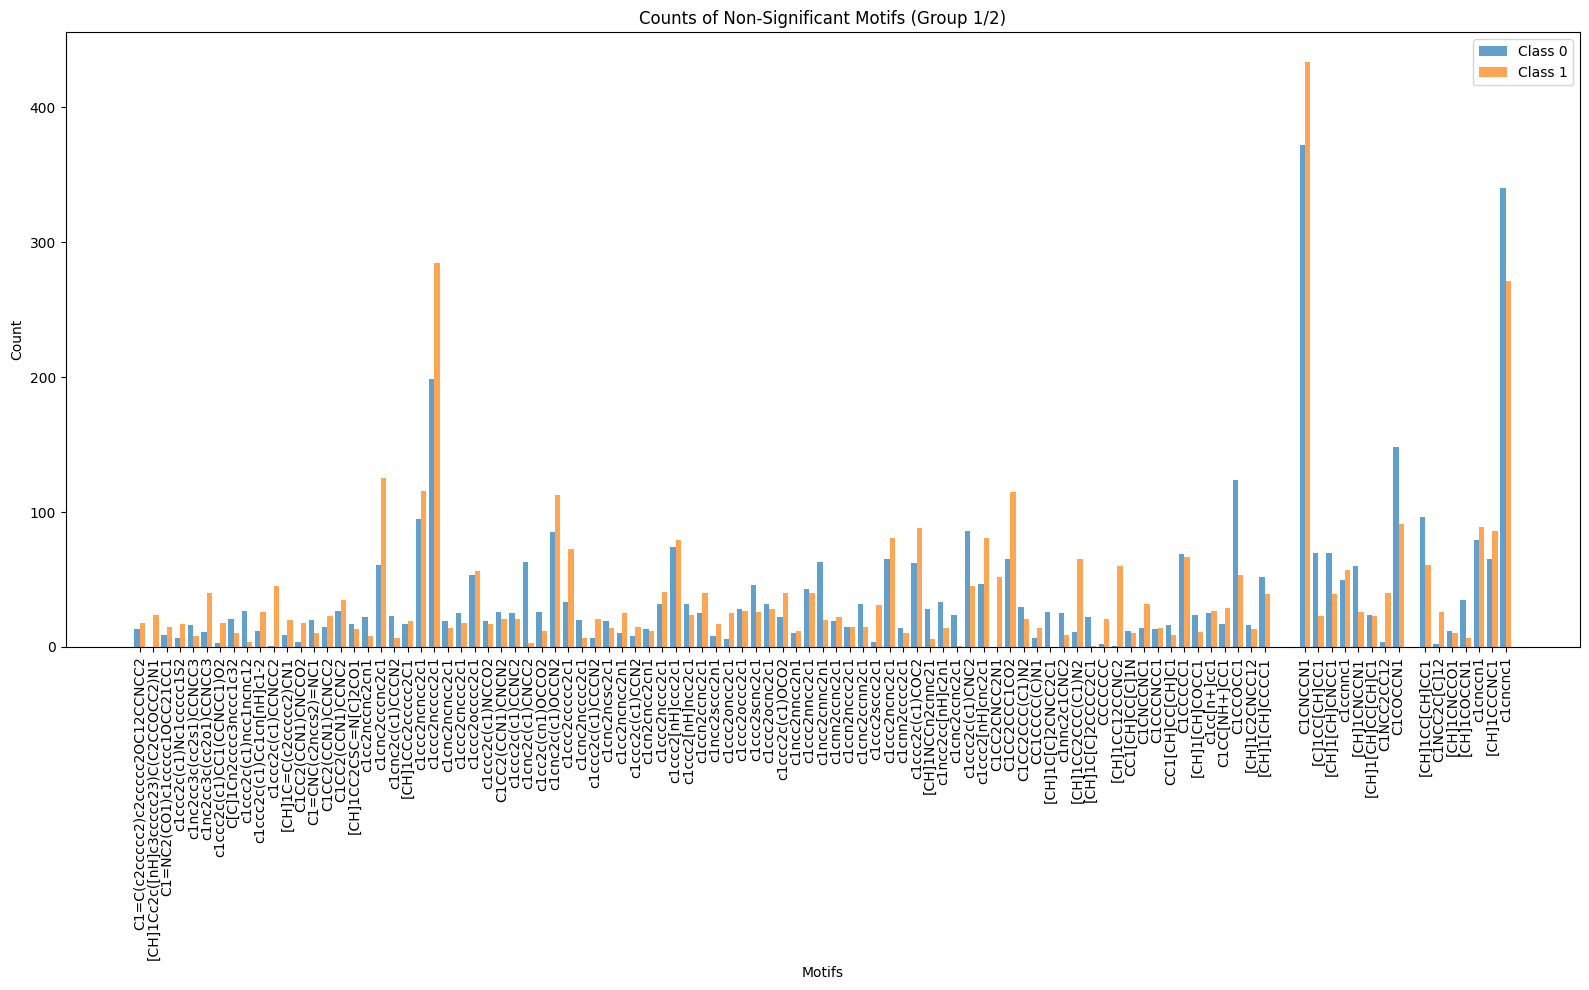

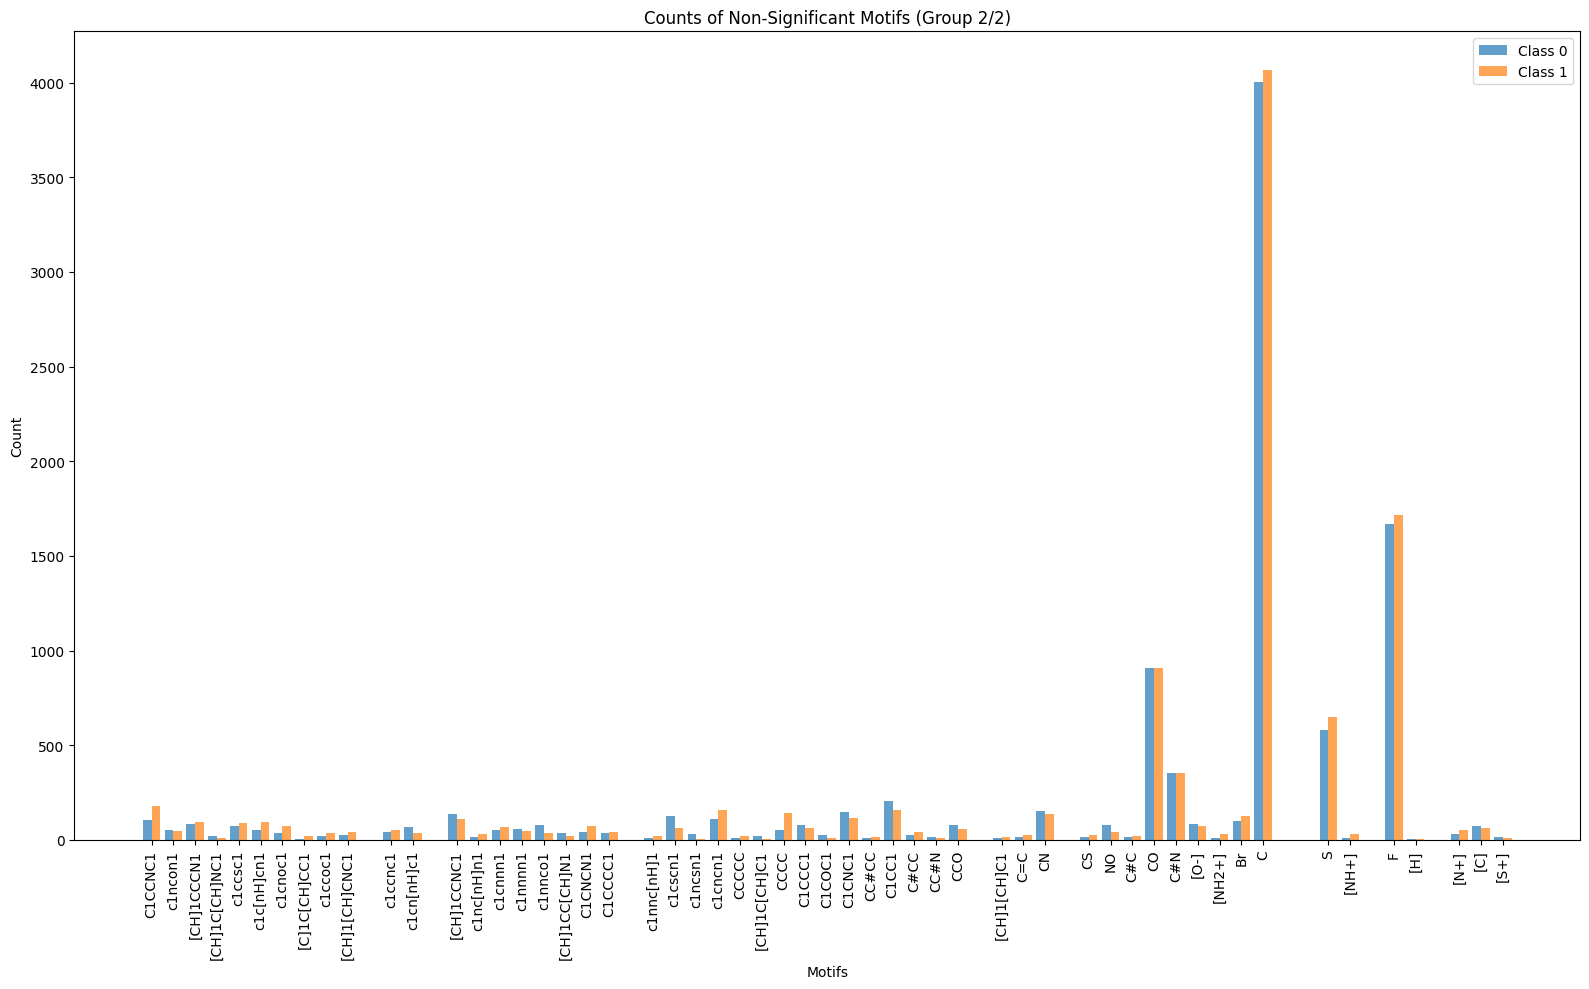

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example data
data = lookup.motifs_length
counter = value_counts

# Create a DataFrame from the data
df = []
classes = [0, 1]
for key, length in data.items():
    counts = counter[key]
    for cls in classes:
        df.append((key, length, cls, counts[cls]))
df = pd.DataFrame(df, columns=['Key', 'Length', 'Class', 'Count'])

# Sort DataFrame by Length in descending order
df = df.sort_values(by='Length', ascending=False)

# Create a mapping of motifs to unique integer values
motif_mapping = {motif: i for i, motif in enumerate(df['Key'].unique())}

# Create a new column for mapped motif numbers using .map
df.loc[:, 'Key_Num'] = df['Key'].map(motif_mapping)

# Split the data into two separate DataFrames for each class
df_class_0 = df[df['Class'] == 0].copy()
df_class_1 = df[df['Class'] == 1].copy()

# Calculate the absolute difference in counts between Class 0 and Class 1 for each motif
df_counts = df.pivot(index='Key', columns='Class', values='Count').fillna(0)
df_counts['Difference'] = abs(df_counts[0] - df_counts[1])

# Set a threshold for significant difference
significant_threshold = 100  # Example threshold, adjust as needed
significant_motifs = df_counts[df_counts['Difference'] > significant_threshold].index

# Separate significant and non-significant motifs
df_significant = df[df['Key'].isin(significant_motifs)].copy()
df_non_significant = df[~df['Key'].isin(significant_motifs)].copy()

# Plot significant motifs
fig, ax = plt.subplots(figsize=(16, 10))

for cls in classes:
    subset = df_significant[df_significant['Class'] == cls]
    ax.bar(subset['Key_Num'] + cls * 0.4, subset['Count'], width=0.4, label=f'Class {cls}', alpha=0.7)

ax.set_title('Counts of Significant Motifs')
ax.set_xlabel('Motifs')
ax.set_ylabel('Count')
ax.set_xticks([motif_mapping[motif] + 0.2 for motif in significant_motifs])
ax.set_xticklabels(significant_motifs, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Plot non-significant motifs in groups of 100
non_sig_motifs = df_non_significant['Key'].unique()
num_groups = int(np.ceil(len(non_sig_motifs) / 100))

for i in range(num_groups):
    fig, ax = plt.subplots(figsize=(16, 10))
    
    start = i * 100
    end = (i + 1) * 100
    current_motifs = non_sig_motifs[start:end]
    df_current = df_non_significant[df_non_significant['Key'].isin(current_motifs)].copy()
    
    for cls in classes:
        subset = df_current[df_current['Class'] == cls]
        ax.bar(subset['Key_Num'] + cls * 0.4, subset['Count'], width=0.4, label=f'Class {cls}', alpha=0.7)

    ax.set_title(f'Counts of Non-Significant Motifs (Group {i + 1}/{num_groups})')
    ax.set_xlabel('Motifs')
    ax.set_ylabel('Count')
    ax.set_xticks([motif_mapping[motif] + 0.2 for motif in current_motifs])
    ax.set_xticklabels(current_motifs, rotation=90)
    ax.legend()
    plt.tight_layout()
    plt.show()


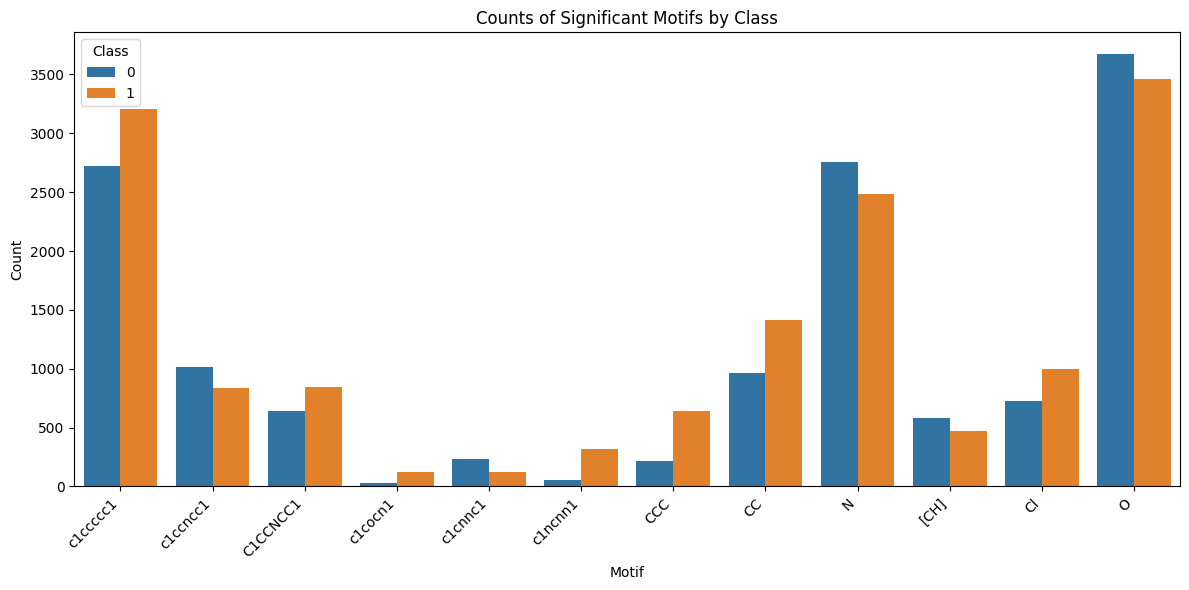

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Key', y='Count', hue='Class', data=df_significant)

# Adding labels and title
plt.xlabel('Motif')
plt.ylabel('Count')
plt.title('Counts of Significant Motifs by Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-ticks for better readability

# Display the plot
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [33]:
df.loc[df['Key'] == '*ON(*)O*']

,Key,Length,Class,Count,Key_Num


In [34]:
df.loc[df['Key'] == '*[N+](=O)[O-]']

,Key,Length,Class,Count,Key_Num


In [35]:
df.loc[df['Key'] == '*[NH+]([O-])O']

,Key,Length,Class,Count,Key_Num


In [36]:
df

,Key,Length,Class,Count,Key_Num
326,C1=C(c2ccccc2)c2ccccc2OC12CCNCC2,21,0,13,0
327,C1=C(c2ccccc2)c2ccccc2OC12CCNCC2,21,1,18,0
307,[CH]1Cc2c([nH]c3ccccc23)C(C2CCOCC2)N1,19,1,24,1
306,[CH]1Cc2c([nH]c3ccccc23)C(C2CCOCC2)N1,19,0,0,1
320,C1=NC2(CO1)c1ccccc1OCC21CC1,16,0,9,2
...,...,...,...,...,...
141,[N+],1,1,54,163
66,[C],1,0,71,164
67,[C],1,1,61,164
270,[S+],1,0,17,165


In [37]:
atom_counts('*[N+](=O)[O-]')

'*1N1O2'

In [38]:
atom_counts('*ON(*)O*')

'*3N1O2'